# Survival Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import json as js
from matplotlib.offsetbox import AnchoredText
import matplotlib
import warnings
import warnings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Load Metadata

In [2]:
clinical = pd.read_csv("metadata/combined_study_clinical_data.tsv", sep="\t",
                      usecols=["Patient ID", "Sample ID", "Cancer Type Detailed", "Progression Free Status", "Progress Free Survival (Months)",
                              "Disease Free (Months)", "Disease Free Status", "Overall Survival Status", "Overall Survival (Months)"])

clinical = clinical.set_index("Sample ID")
clinical = clinical[~clinical["Overall Survival Status"].isna()]
clinical = clinical[~clinical["Overall Survival (Months)"].isna()]
clinical_sample_id = list(clinical.index)

In [3]:
tcga_metadata = pd.read_csv("metadata/TCGA_metadata.csv")
brca_metadata = tcga_metadata[(tcga_metadata["TSS"] == "breast invasive carcinoma") & (~tcga_metadata["Sample"].str.contains("normal"))]
brca_metadata = brca_metadata.set_index("TCGAbarcode", drop = False)
print(brca_metadata.shape)
brca_metadata.head(3)

(1103, 5)


,UUID,TCGAbarcode,TSS,Sample,TCGA_abb
TCGAbarcode,,,,,
TCGA-AO-A03L-01A-41R-A057-13,cc403178-7aa9-47ce-b80b-1019be418539,TCGA-AO-A03L-01A-41R-A057-13,breast invasive carcinoma,primary solid tumor,BRCA
TCGA-A2-A0CM-01A-31R-A035-13,4bfa3f47-d0f3-456a-b50b-2c277a58346c,TCGA-A2-A0CM-01A-31R-A035-13,breast invasive carcinoma,primary solid tumor,BRCA
TCGA-E2-A3DX-01A-21R-A214-13,b6046325-0290-46a1-842d-f60820c8dbe8,TCGA-E2-A3DX-01A-21R-A214-13,breast invasive carcinoma,primary solid tumor,BRCA


## Load Counts

In [4]:
with open('data/counts/brca_sig_cell_lines_loci.json', 'r') as f:
    brca_sample_loci = js.load(f)
    f.close()
with open('data/counts/brca_cpm_map.json', 'r') as f:
    brca_cpm_map = js.load(f)
    f.close()

# Load significant overlaps


In [5]:
sig_loci= pd.read_csv("results/thresholded_oncRNAs.bed", header=None, sep="\t")[3]
sig_loci

0         chr6:27815103-27815138:+
1         chr7:13735449-13735471:-
2         chr7:29921213-29921331:-
3       chr9:126496950-126496971:-
4      chr11:112396454-112396473:+
                  ...             
108       chr1:84497400-84497524:+
109       chr9:14613887-14613949:-
110      chr12:11171716-11171829:+
111     chr2:111153783-111153820:+
112     chr1:226365958-226366045:-
Name: 3, Length: 113, dtype: object

## Create RNA Expression Matrix

In [6]:
brca_exp_data = np.zeros((1103, 113))
i = 0
for sample in brca_metadata["TCGAbarcode"]:
    j = 0
    for rna in sig_loci:
        if rna in brca_sample_loci[sample]:
            brca_exp_data[i,j] = brca_sample_loci[sample][rna] * brca_cpm_map[sample] #Exp data; cpm normalized.
        j += 1
    i += 1 

In [7]:
brca_df = pd.DataFrame(brca_exp_data, columns=sig_loci, index=brca_metadata["TCGAbarcode"])
brca_df["Patient ID"] = [_id[:15] for _id in brca_df.index]
brca_df = brca_df.reset_index().rename(columns={"index":"TCGAbarcode"})

In [8]:
clinical_sample_id = list(clinical.index)
#Clinical data for cancer
match_id = [_id for _id in clinical_sample_id if _id in brca_df["Patient ID"].values]
cancer_clinical = clinical.loc[match_id, ["Overall Survival Status", "Overall Survival (Months)"]]
cancer_clinical["E"] = cancer_clinical["Overall Survival Status"].apply(lambda x: 1 if x == "DECEASED" else 0)
cancer_clinical["T"] = cancer_clinical["Overall Survival (Months)"].apply(lambda x: x/12)
cancer_clinical["T"] = cancer_clinical["T"].clip(upper=10) #Clip max 10 years

In [9]:
brca_final = brca_df.merge(cancer_clinical, how="inner", left_on="Patient ID", right_index=True)
print(brca_final.shape)
brca_final.head(3)

(1081, 119)


,TCGAbarcode,chr6:27815103-27815138:+,chr7:13735449-13735471:-,chr7:29921213-29921331:-,chr9:126496950-126496971:-,chr11:112396454-112396473:+,chr12:71664021-71664096:+,chr16:48178002-48178029:-,chr17:38604595-38604621:-,chr20:48679752-48679775:-,...,chr1:84497400-84497524:+,chr9:14613887-14613949:-,chr12:11171716-11171829:+,chr2:111153783-111153820:+,chr1:226365958-226366045:-,Patient ID,Overall Survival Status,Overall Survival (Months),E,T
0,TCGA-AO-A03L-01A-41R-A057-13,0.542352,0.0,0.0,0.0,0.0,0.0,0.0,3.254112,0.0,...,0.0,0.000000,0.0,0.000000,0.0,TCGA-AO-A03L-01,LIVING,80.284052,0,6.690338
1,TCGA-A2-A0CM-01A-31R-A035-13,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.593813,0.0,0.593813,0.0,TCGA-A2-A0CM-01,DECEASED,24.788769,1,2.065731
2,TCGA-E2-A3DX-01A-21R-A214-13,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,TCGA-E2-A3DX-01,LIVING,43.561166,0,3.630097


# Thresholding for Survival

In [10]:
warnings.filterwarnings('ignore')
surv_sig_loci = []
surv_sig_th = []
for rna in sig_loci:
    sorted_exp = np.sort(brca_final[rna])
    initial_th_index = np.nonzero(sorted_exp)[0][0] #Start from first nonzero
    for i in range(initial_th_index, 1031): #Range ensures we have at least 50 samples considered as high expression in stratification.
        th = sorted_exp[i]
        groups = []
        for exp in brca_final[rna]:
            if exp >= th:
                groups.append("High")
            else:
                groups.append("Low")
                
        test = pd.DataFrame(brca_final["T"])
        test["E"] = pd.DataFrame(brca_final["E"])
        test[rna] = groups
        test_res = multivariate_logrank_test(test['T'], test[rna], test['E'])
        if test_res.p_value <= 0.05:          
            surv_sig_loci.append(rna)
            surv_sig_th.append(th)
            break
len(surv_sig_loci)

23

In [12]:
T = brca_final["T"].copy()
E = brca_final["E"].copy()

## RNA 1

154


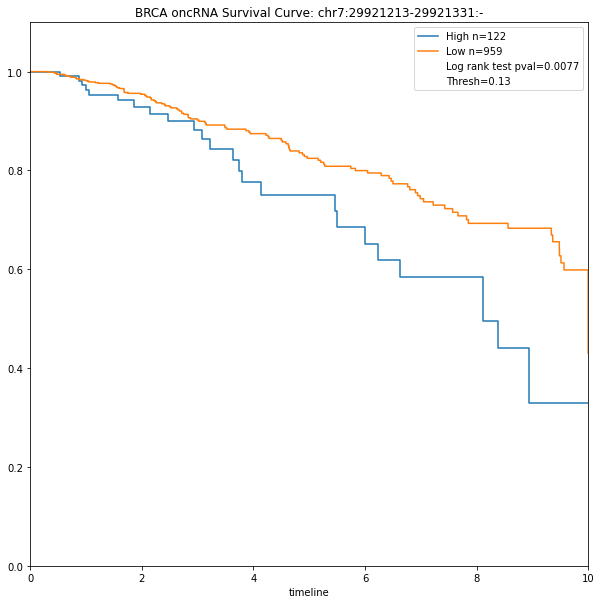

In [13]:
kmf = KaplanMeierFitter()
thresh = surv_sig_th[0]
thresh = 0.13

rna = surv_sig_loci[0]

i1 = brca_final[rna] >= thresh
i2 = brca_final[rna] < thresh

kmf.fit(T[i1], E[i1], label=f'High n={sum(i1)}')
fig = plt.figure(figsize=(10,10))
ax = kmf.plot(ci_show=False)
kmf.fit(T[i2], E[i2], label=f'Low n={sum(i2)}')
ax = kmf.plot(ax=ax, ci_show=False)
plt.title(f"BRCA oncRNA Survival Curve: {rna}")
plt.ylim(0,1.1)
plt.xlim(0,10)

groups = []
for exp in brca_final[rna]:
    if exp >= thresh:
        groups.append("High")
    else:
        groups.append("Low")       
test = pd.DataFrame(brca_final["T"])
test["E"] = pd.DataFrame(brca_final["E"])
test[rna] = groups
test_res = multivariate_logrank_test(test['T'], test[rna], test['E'])
test_res.summary

plt.plot([], [], ' ', label=f"Log rank test pval={round(test_res.p_value, 4)}")
plt.plot([], [], ' ', label=f"Thresh={round(thresh, 4)}")
plt.legend()
print(sum(brca_final[rna] != 0))

# RNA 2

269


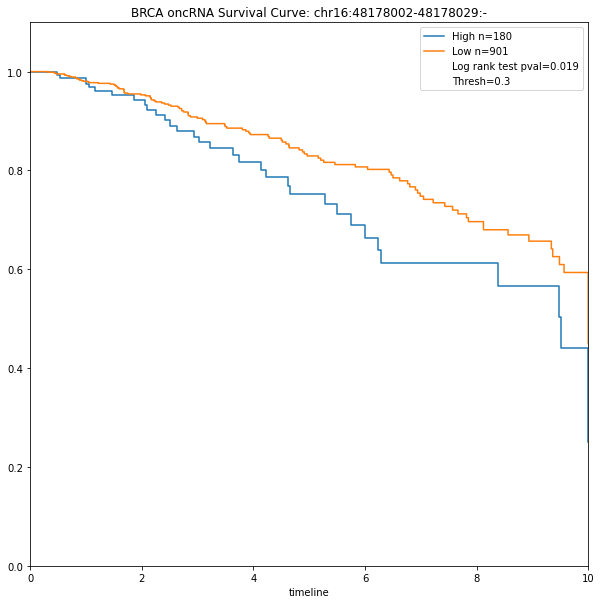

In [14]:
kmf = KaplanMeierFitter()
thresh = surv_sig_th[1]
rna = surv_sig_loci[1]
thresh = 0.3


i1 = brca_final[rna] >= thresh
i2 = brca_final[rna] < thresh

kmf.fit(T[i1], E[i1], label=f'High n={sum(i1)}')
fig = plt.figure(figsize=(10,10))
ax = kmf.plot(ci_show=False)
kmf.fit(T[i2], E[i2], label=f'Low n={sum(i2)}')
ax = kmf.plot(ax=ax, ci_show=False)
plt.title(f"BRCA oncRNA Survival Curve: {rna}")
plt.ylim(0,1.1)
plt.xlim(0,10)

groups = []
for exp in brca_final[rna]:
    if exp >= thresh:
        groups.append("High")
    else:
        groups.append("Low")       
test = pd.DataFrame(brca_final["T"])
test["E"] = pd.DataFrame(brca_final["E"])
test[rna] = groups
test_res = multivariate_logrank_test(test['T'], test[rna], test['E'])
test_res.summary

plt.plot([], [], ' ', label=f"Log rank test pval={round(test_res.p_value, 4)}")
plt.plot([], [], ' ', label=f"Thresh={round(thresh, 4)}")
plt.legend()
print(sum(brca_final[rna] != 0))

# RNA 3

278


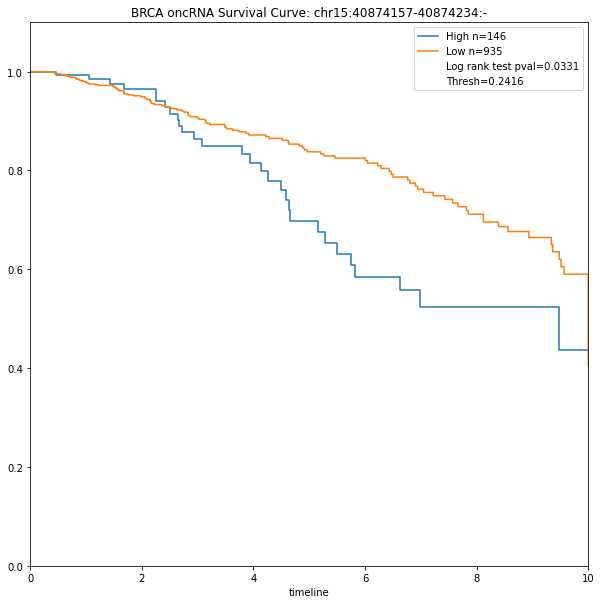

In [15]:
kmf = KaplanMeierFitter()
thresh = surv_sig_th[9]
rna = surv_sig_loci[9]

i1 = brca_final[rna] >= thresh
i2 = brca_final[rna] < thresh

kmf.fit(T[i1], E[i1], label=f'High n={sum(i1)}')
fig = plt.figure(figsize=(10,10))
ax = kmf.plot(ci_show=False)
kmf.fit(T[i2], E[i2], label=f'Low n={sum(i2)}')
ax = kmf.plot(ax=ax, ci_show=False)
plt.title(f"BRCA oncRNA Survival Curve: {rna}")
plt.ylim(0,1.1)
plt.xlim(0,10)

groups = []
for exp in brca_final[rna]:
    if exp >= thresh:
        groups.append("High")
    else:
        groups.append("Low")       
test = pd.DataFrame(brca_final["T"])
test["E"] = pd.DataFrame(brca_final["E"])
test[rna] = groups
test_res = multivariate_logrank_test(test['T'], test[rna], test['E'])
test_res.summary

plt.plot([], [], ' ', label=f"Log rank test pval={round(test_res.p_value, 4)}")
plt.plot([], [], ' ', label=f"Thresh={round(thresh, 4)}")
plt.legend()
print(sum(brca_final[rna] != 0))

# RNA 4

278


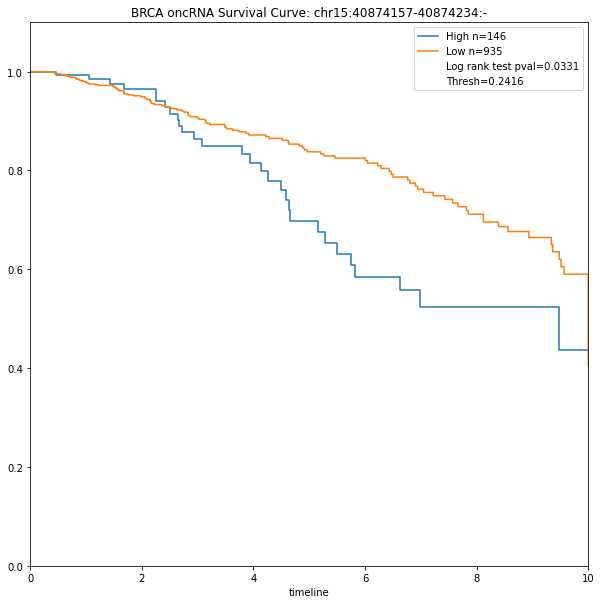

In [21]:
kmf = KaplanMeierFitter()
thresh = surv_sig_th[9]
rna = surv_sig_loci[9]

i1 = brca_final[rna] >= thresh
i2 = brca_final[rna] < thresh

kmf.fit(T[i1], E[i1], label=f'High n={sum(i1)}')
fig = plt.figure(figsize=(10,10))
ax = kmf.plot(ci_show=False)
kmf.fit(T[i2], E[i2], label=f'Low n={sum(i2)}')
ax = kmf.plot(ax=ax, ci_show=False)
plt.title(f"BRCA oncRNA Survival Curve: {rna}")
plt.ylim(0,1.1)
plt.xlim(0,10)

groups = []
for exp in brca_final[rna]:
    if exp >= thresh:
        groups.append("High")
    else:
        groups.append("Low")       
test = pd.DataFrame(brca_final["T"])
test["E"] = pd.DataFrame(brca_final["E"])
test[rna] = groups
test_res = multivariate_logrank_test(test['T'], test[rna], test['E'])
test_res.summary

plt.plot([], [], ' ', label=f"Log rank test pval={round(test_res.p_value, 4)}")
plt.plot([], [], ' ', label=f"Thresh={round(thresh, 4)}")
plt.legend()
print(sum(brca_final[rna] != 0))


# Conclusion
Here we see that there are oncRNAs that can are significantly associated with poor survival when used to stratify BRCA patients. None of the differentialy expressed oncRNAs identified in the metastatic cell lines were found to be associated with poorer survival.